In [1]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Reshape, Conv2D, add, LeakyReLU
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, Callback
import scipy.io as sio 
import numpy as np
import math
import time
tf.compat.v1.reset_default_graph()

In [2]:
envir = 'indoor' #'indoor' or 'outdoor'
# image params
img_height = 32
img_width = 32
img_channels = 2 
img_total = img_height*img_width*img_channels
# network params
residual_num = 2
encoded_dim = 64  #compress rate=1/4->dim.=512, compress rate=1/16->dim.=128, compress rate=1/32->dim.=64, compress rate=1/64->dim.=32

In [3]:
# Bulid the autoencoder model of CsiNet
def residual_network(x, residual_num, encoded_dim):
    def add_common_layers(y):
        y = BatchNormalization()(y)
        y = LeakyReLU()(y)
        return y
    def residual_block_decoded(y):
        shortcut = y
        y = Conv2D(8, kernel_size=(3, 3), padding='same', data_format='channels_first')(y)
        y = add_common_layers(y)
        
        y = Conv2D(16, kernel_size=(3, 3), padding='same', data_format='channels_first')(y)
        y = add_common_layers(y)
        
        y = Conv2D(2, kernel_size=(3, 3), padding='same', data_format='channels_first')(y)
        y = BatchNormalization()(y)

        y = add([shortcut, y])
        y = LeakyReLU()(y)

        return y
    
    x = Conv2D(2, (3, 3), padding='same', data_format="channels_first")(x)
    x = add_common_layers(x)
    
    
    x = Reshape((img_total,))(x)
    encoded = Dense(encoded_dim, activation='linear')(x)
    
    x = Dense(img_total, activation='linear')(encoded)
    x = Reshape((img_channels, img_height, img_width,))(x)
    for i in range(residual_num):
        x = residual_block_decoded(x)
    
    x = Conv2D(2, (3, 3), activation='sigmoid', padding='same', data_format="channels_first")(x)

    return x

In [4]:
image_tensor = Input(shape=(img_channels, img_height, img_width))
network_output = residual_network(image_tensor, residual_num, encoded_dim)
autoencoder = Model(inputs=[image_tensor], outputs=[network_output])
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 32, 32)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 2, 32, 32)    38          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2, 32, 32)   128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 2, 32, 32)    0           ['batch_normalization[0][0]']

In [5]:
# Data loading
if envir == 'indoor':
    mat = sio.loadmat('data/DATA_Htrainin.mat') 
    x_train = mat['HT'] # array
    mat = sio.loadmat('data/DATA_Hvalin.mat')
    x_val = mat['HT'] # array
    mat = sio.loadmat('data/DATA_Htestin.mat')
    x_test = mat['HT'] # array

elif envir == 'outdoor':
    mat = sio.loadmat('data/DATA_Htrainout.mat') 
    x_train = mat['HT'] # array
    mat = sio.loadmat('data/DATA_Hvalout.mat')
    x_val = mat['HT'] # array
    mat = sio.loadmat('data/DATA_Htestout.mat')
    x_test = mat['HT'] # array

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train = np.reshape(x_train, (len(x_train), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_val = np.reshape(x_val, (len(x_val), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format

In [6]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses_train = []
        self.losses_val = []

    def on_batch_end(self, batch, logs={}):
        self.losses_train.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses_val.append(logs.get('val_loss'))

In [7]:
history = LossHistory()
file = 'CsiNet_'+(envir)+'_dim'+str(encoded_dim)+time.strftime('_%m_%d')
path = 'result/TensorBoard_%s' %file

autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=200,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[history,
                           TensorBoard(log_dir = path)])

filename = 'result/trainloss_%s.csv'%file
loss_history = np.array(history.losses_train)
np.savetxt(filename, loss_history, delimiter=",")

filename = 'result/valloss_%s.csv'%file
loss_history = np.array(history.losses_val)
np.savetxt(filename, loss_history, delimiter=",")

Epoch 1/15
500/500 [==============================] - 24s 37ms/step - loss: 7.4420e-04 - val_loss: 4.7539e-04
Epoch 2/15
500/500 [==============================] - 16s 33ms/step - loss: 4.0641e-04 - val_loss: 3.7477e-04
Epoch 3/15
500/500 [==============================] - 17s 34ms/step - loss: 3.1049e-04 - val_loss: 2.8996e-04
Epoch 4/15
500/500 [==============================] - 17s 34ms/step - loss: 2.2748e-04 - val_loss: 2.2983e-04
Epoch 5/15
500/500 [==============================] - 17s 34ms/step - loss: 1.4923e-04 - val_loss: 1.4997e-04
Epoch 6/15
500/500 [==============================] - 18s 35ms/step - loss: 1.0906e-04 - val_loss: 1.1056e-04
Epoch 7/15
500/500 [==============================] - 18s 36ms/step - loss: 8.9194e-05 - val_loss: 8.9398e-05
Epoch 8/15
500/500 [==============================] - 19s 37ms/step - loss: 7.6430e-05 - val_loss: 7.9387e-05
Epoch 9/15
500/500 [==============================] - 19s 38ms/step - loss: 6.6966e-05 - val_loss: 7.4211e-05
Epoch 10/1

In [8]:
#Testing data
tStart = time.time()
x_hat = autoencoder.predict(x_test)
print(x_hat.shape)
tEnd = time.time()
print ("It cost %f sec" % ((tEnd - tStart)/x_test.shape[0]))

625/625 [==============================] - 4s 6ms/step
(20000, 2, 32, 32)
It cost 0.000268 sec


In [9]:
# Calcaulating the NMSE and rho
if envir == 'indoor':
    mat = sio.loadmat('data/DATA_HtestFin_all.mat')
    X_test = mat['HF_all']# array

elif envir == 'outdoor':
    mat = sio.loadmat('data/DATA_HtestFout_all.mat')
    X_test = mat['HF_all']# array

X_test = np.reshape(X_test, (len(X_test), img_height, 125))
x_test_real = np.reshape(x_test[:, 0, :, :], (len(x_test), -1))
x_test_imag = np.reshape(x_test[:, 1, :, :], (len(x_test), -1))
x_test_C = x_test_real-0.5 + 1j*(x_test_imag-0.5)
x_hat_real = np.reshape(x_hat[:, 0, :, :], (len(x_hat), -1))
x_hat_imag = np.reshape(x_hat[:, 1, :, :], (len(x_hat), -1))
x_hat_C = x_hat_real-0.5 + 1j*(x_hat_imag-0.5)
x_hat_F = np.reshape(x_hat_C, (len(x_hat_C), img_height, img_width))
X_hat = np.fft.fft(np.concatenate((x_hat_F, np.zeros((len(x_hat_C), img_height, 257-img_width))), axis=2), axis=2)
X_hat = X_hat[:, :, 0:125]

n1 = np.sqrt(np.sum(np.conj(X_test)*X_test, axis=1))
n1 = n1.astype('float64')
n2 = np.sqrt(np.sum(np.conj(X_hat)*X_hat, axis=1))
n2 = n2.astype('float64')
aa = abs(np.sum(np.conj(X_test)*X_hat, axis=1))
rho = np.mean(aa/(n1*n2), axis=1)
X_hat = np.reshape(X_hat, (len(X_hat), -1))
X_test = np.reshape(X_test, (len(X_test), -1))
power = np.sum(abs(x_test_C)**2, axis=1)
power_d = np.sum(abs(X_hat)**2, axis=1)
mse = np.sum(abs(x_test_C-x_hat_C)**2, axis=1)

print("In "+envir+" environment")
print("When dimension is", encoded_dim)
print("NMSE is ", 10*math.log10(np.mean(mse/power)))
print("Correlation is ", np.mean(rho))
filename = "result/decoded_%s.csv"%file
x_hat1 = np.reshape(x_hat, (len(x_hat), -1))
np.savetxt(filename, x_hat1, delimiter=",")
filename = "result/rho_%s.csv"%file
np.savetxt(filename, rho, delimiter=",")


C:\Users\Omar\AppData\Local\Temp\ipykernel_2936\4166756425.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  n1 = n1.astype('float64')
C:\Users\Omar\AppData\Local\Temp\ipykernel_2936\4166756425.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  n2 = n2.astype('float64')


In indoor environment
When dimension is 512
NMSE is  -10.262394831981618
Correlation is  0.9519933909424321


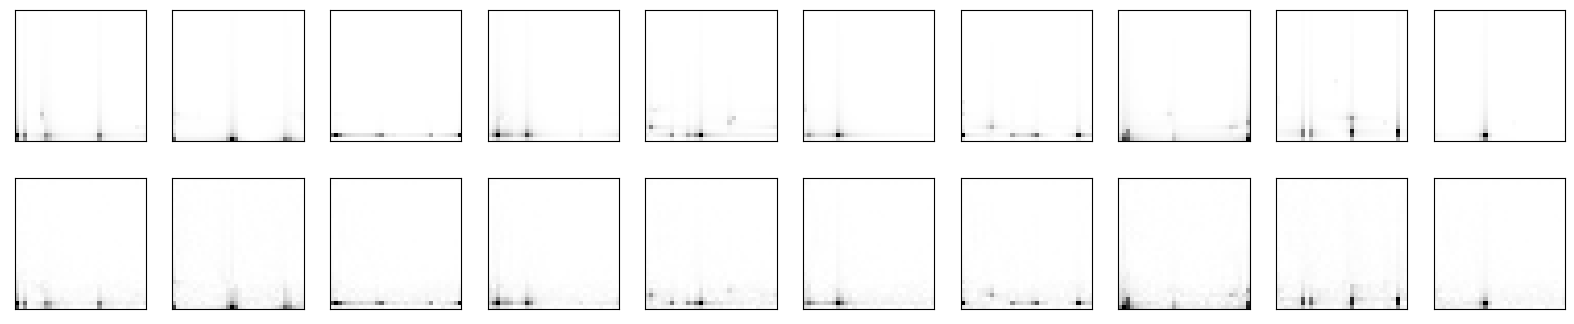

In [10]:
import matplotlib.pyplot as plt
'''abs'''
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display origoutal
    ax = plt.subplot(2, n, i + 1 )
    x_testplo = abs(x_test[i, 0, :, :]-0.5 + 1j*(x_test[i, 1, :, :]-0.5))
    plt.imshow(np.max(np.max(x_testplo))-x_testplo.T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    decoded_imgsplo = abs(x_hat[i, 0, :, :]-0.5 
                          + 1j*(x_hat[i, 1, :, :]-0.5))
    plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
plt.show()


# save
# serialize model to JSON
model_json = autoencoder.to_json()
outfile = "result/model_%s.json"%file
with open(outfile, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
outfile = "result/model_%s.h5"%file
autoencoder.save_weights(outfile)